In [ ]:
from sklearn.datasets import load_boston
from sklearn.model_selection import cross_val_score
from sklearn.ensemble import RandomForestRegressor
import pandas as pd
import numpy as np

boston = load_boston()
boston_df = pd.DataFrame(boston.data,columns=boston.feature_names)
boston_df['PRICE'] = boston.target
boston_df.head()

In [ ]:
y_target = boston_df.PRICE
X_data = boston_df.drop(['PRICE'],axis=1)

rf = RandomForestRegressor(random_state=0,n_estimators=1000)
neg_mse_scores = cross_val_score(rf,X_data,y_target,scoring='neg_mean_squared_error',cv=5)
rmse_scores=np.sqrt(-1*neg_mse_scores)
avg_rmse = np.mean(rmse_scores)

print('5 교차 검증의 개별 Negative MSE scores: ', np.round(neg_mse_scores, 2))
print('5 교차 검증의 개별 RMSE scores: ', np.round(rmse_scores, 2))
print('5 교차 검증의 평균 RMSE: ', np.round(avg_rmse, 2))

### 자전거 수요 예측


[도전 과제]

캐글의 자전거 대여 수요 예측을 아래와 같이 수행하세요

- 데이터는 https://www.kaggle.com/c/bike-sharing-demand/data 에서 train.csv를 다운로드 받아 이용
    - 선형회귀, Ridge, Lasso 모델로 예측모델 생성
    - 문자열을 datetime 타입으로 변경
    - 종속변수 정규성 개선위한 로그 변환
    - 평가지표 : RMSLE, RMSE, MAE
- 'year', month', 'day', hour'등의 피처들을 One Hot Encoding하여 회귀모델의 예측 성능 비교
- 회귀 트리를 이용해 회귀 예측모델 및 평가(RMSLE, RMSE, MAE)

In [28]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

bike_df = pd.read_csv('dataset/bike-sharing-demand/train.csv')
bike_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [29]:
bike_df['datetime'] = bike_df.datetime.apply(pd.to_datetime)
bike_df.head(2)

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,2011-01-01 00:00:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,2011-01-01 01:00:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40


In [30]:
bike_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   datetime    10886 non-null  datetime64[ns]
 1   season      10886 non-null  int64         
 2   holiday     10886 non-null  int64         
 3   workingday  10886 non-null  int64         
 4   weather     10886 non-null  int64         
 5   temp        10886 non-null  float64       
 6   atemp       10886 non-null  float64       
 7   humidity    10886 non-null  int64         
 8   windspeed   10886 non-null  float64       
 9   casual      10886 non-null  int64         
 10  registered  10886 non-null  int64         
 11  count       10886 non-null  int64         
dtypes: datetime64[ns](1), float64(3), int64(8)
memory usage: 1020.7 KB


In [31]:
bike_df['year'] = bike_df.datetime.apply(lambda x:x.year)
bike_df['month'] = bike_df.datetime.apply(lambda x:x.month)
bike_df['day'] = bike_df.datetime.apply(lambda x:x.day)
bike_df['hour'] = bike_df.datetime.apply(lambda x:x.hour)


In [32]:
bike_df.drop(['datetime','casual','registered'],axis=1,inplace=True)

In [51]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

def rmsle(y,pred):
    log_y= np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred)**2
    rmsle= np.sqrt(np.mean(squared_error)) # 1/n(합): 평균
    return rmsle

def rmse(y,pred):
    rmse= np.sqrt(mean_squared_error(y,pred))  # 루트(잔차에 대한 평균)
    return rmse

def evaluate_regr(y,pred):
    rmsle_val = rmsle(y,pred)
    rmse_val = rmse(y,pred)
    mae_val = mean_absolute_error(y,pred)
    print('RMSLE: {0:.4f}, RMSE: {1:.4f}, MAE:{2:.4f}'.format(rmsle_val,rmse_val,mae_val))
    


In [52]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
y_target = bike_df['count']  #종속변수
X_features = bike_df.drop(['count'],axis=1) #독립변수

X_train, X_test, y_train, y_test = train_test_split(X_features,y_target,\
                                                   test_size=0.3,random_state=0)

lr= LinearRegression()
lr.fit(X_train,y_train)
pred = lr.predict(X_test)
evaluate_regr(y_test,pred)


RMSLE: 1.1647, RMSE: 140.8996, MAE:105.9244


<AxesSubplot:xlabel='count', ylabel='Density'>

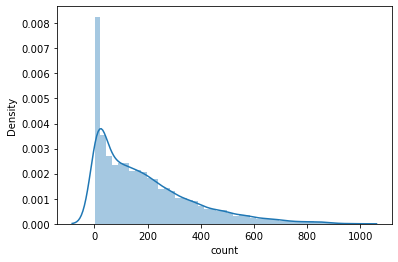

In [53]:
y_target = bike_df['count']
sns.distplot(y_target)

<AxesSubplot:xlabel='count', ylabel='Density'>

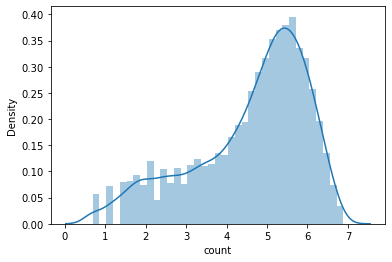

In [54]:
y_log_transform = np.log1p(y_target) # 로그로 정규분포 가깝게 만들기
sns.distplot(y_log_transform)

In [55]:
y_target_log = np.log1p(y_target)

# 로그 변환된 y_target_log를 반영해서 데이터셋 분할
X_train, X_test, y_train, y_test = train_test_split(X_features,y_target_log,
                                                   test_size=0.3, random_state=0)

lr= LinearRegression()
lr.fit(X_train, y_train)
pred = lr.predict(X_test)

# 로그변환해줬던거 지수로 다시 변경 
y_test_exp = np.expm1(y_test)
pred_exp = np.expm1(pred)

evaluate_regr(y_test_exp,pred_exp)

RMSLE: 1.0168, RMSE: 162.5943, MAE:109.2862


<AxesSubplot:>

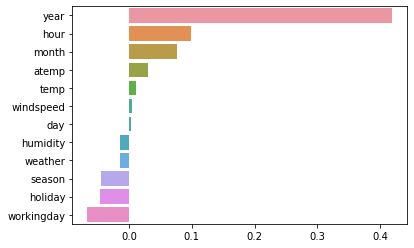

In [56]:
coef = pd.Series(lr.coef_ , index=X_features.columns)
coef_sort = coef.sort_values(ascending=False)

# coef : 기울기 매개변수인 w : 계수(coefficient)

sns.barplot(x=coef_sort.values, y=coef_sort.index)
# x : 각 변수별 W  (values값)
# y: index들 

In [57]:
# 'year', month', 'day', hour'등의 피처들을 One Hot Encoding

X_features_ohe = pd.get_dummies(X_features, columns= ['year', 'month','day', 'hour', 'holiday',
                                              'workingday','season','weather'])


In [58]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LinearRegression, Ridge, Lasso

# 원핫 인코딩 적용된 데이터셋 학습/예측으로 분할
X_train, X_test, y_train, y_test = train_test_split(X_features_ohe, y_target_log,
                                                    test_size=0.3, random_state=0)
# 성능평가 (default는 지수함수가 아닌것  )
def get_model_predict(model, X_train, X_test, y_train, y_test, is_expm1=False):
    model.fit(X_train, y_train)
    pred = model.predict(X_test)
    if is_expm1 :
        y_test = np.expm1(y_test)
        pred = np.expm1(pred)
    print('<<<',model.__class__.__name__,'>>>')
    evaluate_regr(y_test, pred)
    
# model별 평가
lr = LinearRegression()
ridge = Ridge(alpha=10)
lasso = Lasso(alpha=0.01)

for model in [lr, ridge, lasso]:
    get_model_predict(model,X_train, X_test, y_train, y_test,is_expm1=True)

<<< LinearRegression >>>
RMSLE: 0.5896, RMSE: 97.6877, MAE:63.3821
<<< Ridge >>>
RMSLE: 0.5901, RMSE: 98.5286, MAE:63.8934
<<< Lasso >>>
RMSLE: 0.6348, RMSE: 113.2188, MAE:72.8027


<AxesSubplot:>

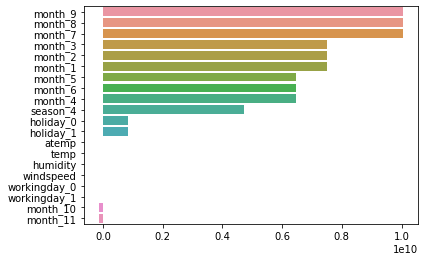

In [59]:
coef = pd.Series(lr.coef_ , index=X_features_ohe.columns)
coef_sort = coef.sort_values(ascending=False)[:20]
sns.barplot(x=coef_sort.values , y=coef_sort.index)

### 캐글 주택 가격: 고급 회귀 기법

In [ ]:
# d아마 라쏘만 좀 다를거임.. 라쏘 파라미터 조정해서 해보기 --> 개선 방안 
# 하이퍼파라미터 튜닝 ...
## 세번재문제 독립변수 분포도 ! 스퀴어 함수로 골라내기... 기준이 1 (1이상인거 왜곡정보 심한것)
# 왜곡 정보가 심한것 로그변환
# 중요한(상관관계 높은) 독립변수에 대해서만 이상치 제거

In [ ]:
import warnings

In [ ]:
from sklearn.metrics import mean_squared_log_error

s=  rmsle(y_test,pred)

s